In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from geopy.distance import geodesic
from sklearn.cluster import DBSCAN
import folium  
from folium.plugins import HeatMap

In [2]:
with open('location-history.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

In [4]:
records = []

for entry in data:

    if "visit" in entry:
        visit = entry["visit"]
        start_time = entry["startTime"]
        end_time = entry["endTime"]
        place = visit.get("topCandidate", {})
        place_id = place.get("placeID", "Unknown")
        lat, lon = place.get("placeLocation", "geo:0,0").replace("geo:", "").split(",")
        
        start_dt = datetime.fromisoformat(start_time[:-6])  
        end_dt = datetime.fromisoformat(end_time[:-6])
        duration = (end_dt - start_dt).seconds / 60  

        records.append({
            "start_time": start_dt,
            "end_time": end_dt,
            "duration_min": duration,
            "latitude": float(lat),
            "longitude": float(lon),
            "place_id": place_id
        })

df = pd.DataFrame(records)
df = df[df["duration_min"] > 10].reset_index(drop=True)
df


,start_time,end_time,duration_min,latitude,longitude,place_id
0,2025-01-22 13:42:28.216,2025-01-22 16:45:00.206,182.516667,38.033553,-78.507977,ChIJ3cRJt0iGs4kRRliLzMIIUUA
1,2025-01-22 13:42:28.216,2025-01-22 16:45:00.206,182.516667,38.031103,-78.513688,ChIJ83CLDFyGs4kRlpbwbea2AWc
2,2025-01-23 17:16:35.259,2025-01-24 18:33:06.406,76.516667,38.033553,-78.507977,ChIJ3cRJt0iGs4kRRliLzMIIUUA
3,2025-01-24 18:33:06.406,2025-01-27 09:05:19.201,872.200000,38.049085,-78.508319,ChIJKaGXibKHs4kRYgunKDXxZho
4,2025-01-27 09:11:57.207,2025-01-27 10:58:28.199,106.500000,38.033553,-78.507977,ChIJ3cRJt0iGs4kRRliLzMIIUUA
...,...,...,...,...,...,...
79,2025-03-11 12:18:03.231,2025-03-14 13:45:36.158,87.533333,38.049085,-78.508319,ChIJKaGXibKHs4kRYgunKDXxZho
80,2025-03-14 14:36:48.664,2025-03-16 07:48:50.523,1032.016667,38.049085,-78.508319,ChIJKaGXibKHs4kRYgunKDXxZho
81,2025-03-16 15:28:01.999,2025-03-16 23:10:09.978,462.116667,38.031619,-78.510846,ChIJB1s6kd6Hs4kRJhuNmO73ZLk
82,2025-03-16 23:10:09.978,2025-03-17 12:40:52.665,810.700000,38.049085,-78.508319,ChIJKaGXibKHs4kRYgunKDXxZho


In [5]:
coords = df[['latitude', 'longitude']].values
db = DBSCAN(eps=0.00005, min_samples=2, metric='haversine').fit(np.radians(coords))

df['cluster'] = db.labels_
df['cluster'].value_counts()

cluster
 2    35
 0    22
 1    15
 4     7
-1     3
 3     2
Name: count, dtype: int64

In [12]:
df = df.sort_values(by="cluster").reset_index(drop=True)
print(df[["latitude", "longitude", "duration_min", "place_id", "cluster"]])

     latitude  longitude  duration_min                     place_id  cluster
0   37.951699 -78.507019    139.650000  ChIJv8IEhj-Fs4kRf_Qa-9XPuSI       -1
1   38.059773 -78.489135     28.316667  ChIJuaZxfcSHs4kRahWpawW3r4o       -1
2   38.058694 -78.494928    106.616667  ChIJr7c4zqmHs4kRRLVHKzvHnzs       -1
3   38.033553 -78.507977    182.516667  ChIJ3cRJt0iGs4kRRliLzMIIUUA        0
4   38.033553 -78.507977    197.300000  ChIJ3cRJt0iGs4kRRliLzMIIUUA        0
..        ...        ...           ...                          ...      ...
79  38.052815 -78.501257     11.850000  ChIJI5T2nbeHs4kRuLewu_1gO8g        4
80  38.052815 -78.501257     15.550000  ChIJI5T2nbeHs4kRuLewu_1gO8g        4
81  38.052815 -78.501257    274.266667  ChIJI5T2nbeHs4kRuLewu_1gO8g        4
82  38.052815 -78.501257     20.516667  ChIJI5T2nbeHs4kRuLewu_1gO8g        4
83  38.053566 -78.500689     20.516667  ChIJS2bqabaHs4kRSFt5o5c1Wos        4

[84 rows x 5 columns]


In [13]:
df.to_csv("clustered_locations.csv", index=False)

In [15]:
df = pd.read_csv("clustered_locations.csv")

# Count occurrences of each cluster
cluster_counts = df["cluster"].value_counts().reset_index()
cluster_counts.columns = ["cluster", "visit_count"]

cluster_duration = df.groupby("cluster")["duration_min"].sum().reset_index()
cluster_duration.columns = ["cluster", "total_duration_min"]

# Find the most frequent place_id for each cluster
representative_place = df.groupby("cluster")["place_id"].agg(lambda x: x.mode()[0]).reset_index()
representative_place.columns = ["cluster", "place_id"]

# Merge visit counts and representative place_id
df_clusters = pd.merge(cluster_counts, representative_place, on="cluster")
df_clusters = pd.merge(df_clusters, cluster_duration, on="cluster")

# Save results
df_clusters.to_csv("cluster_summary.csv", index=False)
print(df_clusters)

   cluster  visit_count                     place_id  total_duration_min
0        2           35  ChIJKaGXibKHs4kRYgunKDXxZho        25592.983333
1        0           22  ChIJ3cRJt0iGs4kRRliLzMIIUUA         3859.116667
2        1           15  ChIJ83CLDFyGs4kRlpbwbea2AWc         2225.250000
3        4            7  ChIJI5T2nbeHs4kRuLewu_1gO8g          382.966667
4       -1            3  ChIJr7c4zqmHs4kRRLVHKzvHnzs          274.583333
5        3            2  ChIJ02ss_OiHs4kRGskTqGAbMdI           57.250000


In [16]:
import googlemaps

gmaps = googlemaps.Client(key="") 

df_clusters = pd.read_csv("cluster_summary.csv")

def get_place_details(place_id):
    """Fetch place name and type from Google Places API."""
    try:
        if pd.isna(place_id) or place_id == "Unknown":
            return "Unknown", "Unknown"

        place = gmaps.place(place_id=place_id)
        name = place.get("result", {}).get("name", "Unknown")
        types = place.get("result", {}).get("types", ["Unknown"])
        return name, types[0] if types else "Unknown"
    
    except Exception as e:
        print(f"Error with place_id {place_id}: {str(e)}")
        return "Unknown", "Unknown"

# Create Empty Columns for Output
df_clusters['place_name'] = "Unknown"
df_clusters['place_type'] = "Unknown"

# Fetch Place Details for Each place_id
for idx, row in df_clusters.iterrows():
    place_id = row["place_id"]
    
    # Skip if already processed
    if row["place_name"] == "Unknown":
        name, place_type = get_place_details(place_id)
        df_clusters.at[idx, "place_name"] = name
        df_clusters.at[idx, "place_type"] = place_type
        

# Display Sample Output
print("\nSample of processed data:")
print(df_clusters.head())


Sample of processed data:
   cluster  visit_count                     place_id  total_duration_min  \
0        2           35  ChIJKaGXibKHs4kRYgunKDXxZho        25592.983333   
1        0           22  ChIJ3cRJt0iGs4kRRliLzMIIUUA         3859.116667   
2        1           15  ChIJ83CLDFyGs4kRlpbwbea2AWc         2225.250000   
3        4            7  ChIJI5T2nbeHs4kRuLewu_1gO8g          382.966667   
4       -1            3  ChIJr7c4zqmHs4kRRLVHKzvHnzs          274.583333   

                      place_name     place_type  
0        Copeley Hill Apartments        premise  
1         University of Virginia     university  
2                  Scott Stadium        stadium  
3  Barracks Road Shopping Center  shopping_mall  
4                      Starbucks           cafe  


In [17]:
df_clusters = df_clusters[df_clusters["cluster"] != -1]
df_clusters

,cluster,visit_count,place_id,total_duration_min,place_name,place_type
0,2,35,ChIJKaGXibKHs4kRYgunKDXxZho,25592.983333,Copeley Hill Apartments,premise
1,0,22,ChIJ3cRJt0iGs4kRRliLzMIIUUA,3859.116667,University of Virginia,university
2,1,15,ChIJ83CLDFyGs4kRlpbwbea2AWc,2225.250000,Scott Stadium,stadium
3,4,7,ChIJI5T2nbeHs4kRuLewu_1gO8g,382.966667,Barracks Road Shopping Center,shopping_mall
5,3,2,ChIJ02ss_OiHs4kRGskTqGAbMdI,57.250000,Costco Wholesale,department_store


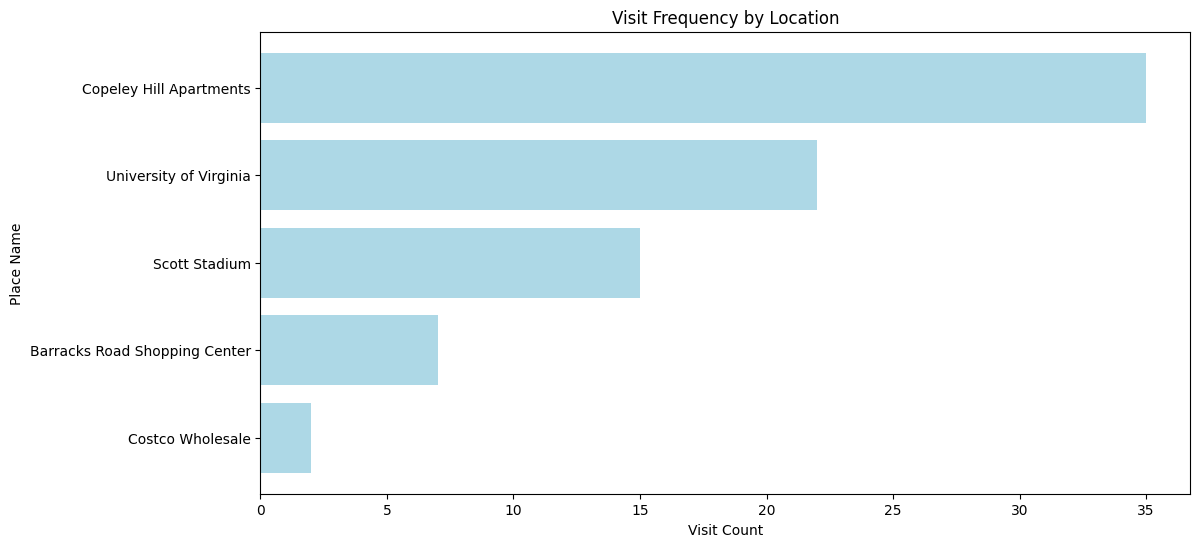

In [32]:
# Sort by visit_count for better visualization
df_sorted = df_clusters.sort_values(by="visit_count", ascending=False)

# Plot
plt.figure(figsize=(12, 6))
plt.barh(df_sorted["place_name"], df_sorted["visit_count"], color= "lightblue")
plt.xlabel("Visit Count")
plt.ylabel("Place Name")
plt.title("Visit Frequency by Location")
plt.gca().invert_yaxis()  # Highest frequency at the top
plt.show()


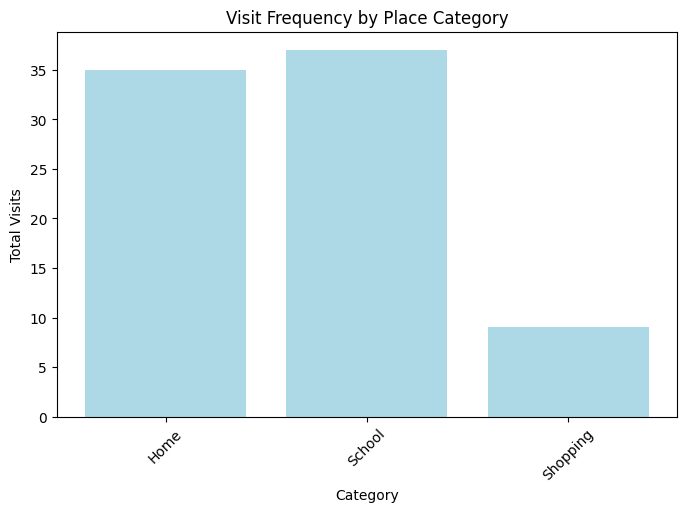

In [26]:
# Define mapping of similar places
place_mapping = {
    "premise": "Home",
    "university": "School",
    "stadium": "School",
    "shopping_mall": "Shopping",
    "department_store": "Shopping"
}

# Apply mapping
df_clusters["general_category"] = df_clusters["place_type"].map(lambda x: place_mapping.get(x, x))

# Aggregate by general category
df_grouped = df_clusters.groupby("general_category")["visit_count"].sum().reset_index()

# Visualize grouped data
plt.figure(figsize=(8, 5))
plt.bar(df_grouped["general_category"], df_grouped["visit_count"], color="lightblue")
plt.xlabel("Category")
plt.ylabel("Total Visits")
plt.title("Visit Frequency by Place Category")
plt.xticks(rotation=45)
plt.show()


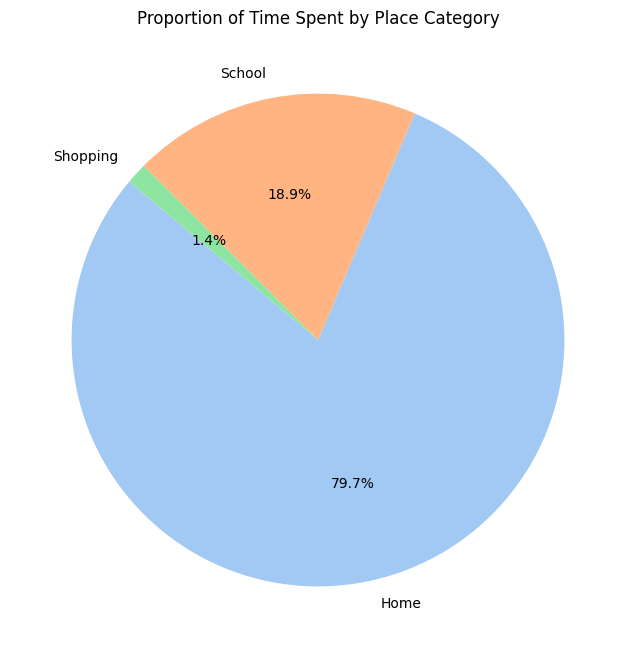

In [28]:
# Aggregate total duration by general category
df_duration_grouped = df_clusters.groupby("general_category")["total_duration_min"].sum().reset_index()

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(df_duration_grouped["total_duration_min"], 
        labels=df_duration_grouped["general_category"], 
        autopct="%1.1f%%", 
        colors=sns.color_palette("pastel"), 
        startangle=140)
plt.title("Proportion of Time Spent by Place Category")
plt.show()

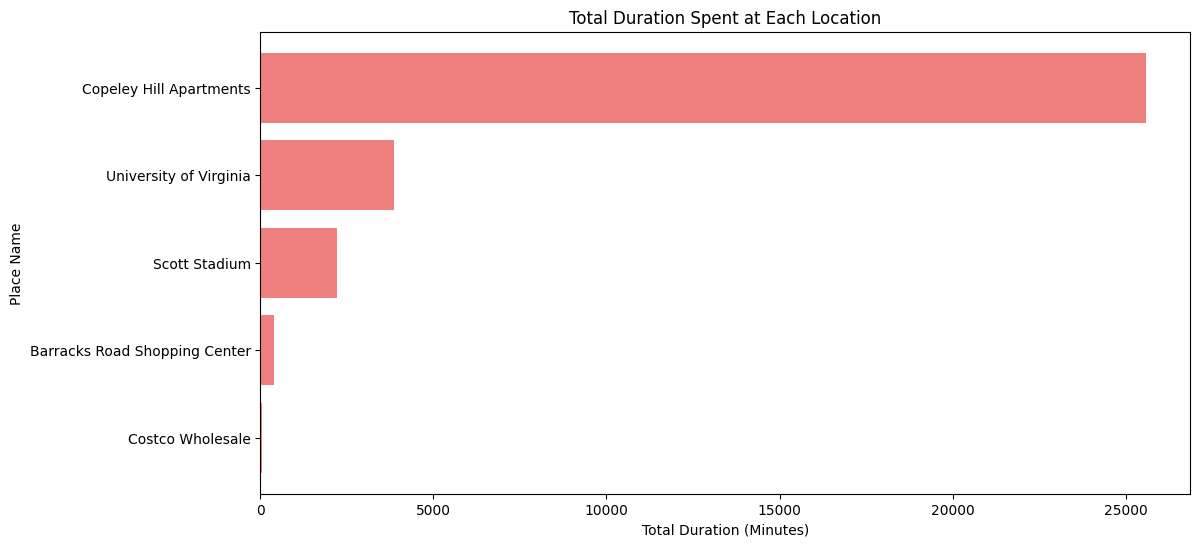

In [23]:
# Sort by total duration
df_sorted = df_clusters.sort_values(by="total_duration_min", ascending=False)

# Plot
plt.figure(figsize=(12, 6))
plt.barh(df_sorted["place_name"], df_sorted["total_duration_min"], color="lightcoral")
plt.xlabel("Total Duration (Minutes)")
plt.ylabel("Place Name")
plt.title("Total Duration Spent at Each Location")
plt.gca().invert_yaxis()
plt.show()



In [29]:
m = folium.Map(location=[df["latitude"].mean(), df["longitude"].mean()], zoom_start=14)

heat_data = df[['latitude', 'longitude']].values.tolist()
HeatMap(heat_data).add_to(m)


m.save("heatmap.html")
m
